In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16



2025-12-08 22:34:49.964303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU elérhető: {gpus}")
else:
    print("Csak CPU elérhető.")

GPU elérhető: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

df = pd.read_csv('../metadata.csv')

data_root_path = "/home/user/datasets/rare_species/"
df['full_path'] = df['file_path'].apply(lambda x: os.path.join(data_root_path, x))

df = df.dropna(subset=['file_path', 'family']).reset_index(drop=True)

df['exists'] = df['full_path'].apply(os.path.exists)
print(f"Number of missing files: {len(df[df['exists'] == False])}")
df = df[df['exists'] == True].reset_index(drop=True)

df = df.drop_duplicates().reset_index(drop=True)
df = df.drop_duplicates(subset='full_path').reset_index(drop=True)

print(f"Cleaned data: {len(df)} images")
print(f"Number of categories (families): {df['family'].nunique()}")

df['family'] = df['family'].astype(str)

Number of missing files: 0
Cleaned data: 11983 images
Number of categories (families): 202


In [4]:
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["family"],
    random_state=SEED
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,
    stratify=train_val_df["family"],
    random_state=SEED
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 9585
Val: 1199
Test: 1199


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    shear_range=0.15,
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)   

val_ds = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

test_ds = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9585 validated image filenames belonging to 202 classes.
Found 1199 validated image filenames belonging to 202 classes.
Found 1199 validated image filenames belonging to 202 classes.


In [6]:
labels = train_ds.classes
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(0.49947889525794686), 1: np.float64(0.6590346534653465), 2: np.float64(0.28244342291371993), 3: np.float64(0.9885519801980198), 4: np.float64(0.4942759900990099), 5: np.float64(1.9771039603960396), 6: np.float64(1.9771039603960396), 7: np.float64(1.9771039603960396), 8: np.float64(0.9885519801980198), 9: np.float64(0.9885519801980198), 10: np.float64(0.32951732673267325), 11: np.float64(0.9885519801980198), 12: np.float64(0.9885519801980198), 13: np.float64(0.39542079207920794), 14: np.float64(0.9885519801980198), 15: np.float64(1.9771039603960396), 16: np.float64(0.39542079207920794), 17: np.float64(1.9771039603960396), 18: np.float64(1.9771039603960396), 19: np.float64(1.9771039603960396), 20: np.float64(1.9771039603960396), 21: np.float64(0.9885519801980198), 22: np.float64(1.9771039603960396), 23: np.float64(0.24713799504950495), 24: np.float64(1.9771039603960396), 25: np.float64(0.28244342291371993), 26: np.float64(0.39542079207920794), 27: np.float64(0.988551980198

In [7]:
def build_model(num_classes):
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

num_classes = len(train_ds.class_indices)
model, base_model = build_model(num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1765233301.046897  227300 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1765233301.050737  227300 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,429,421 (16.90 MB)

 Trainable params: 379,850 (1.45 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint1 = ModelCheckpoint("best_phase1_new.h5", save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint1, reduce_lr]
)

Epoch 1/20


2025-12-08 22:35:20.774415: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f7008005e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-08 22:35:20.774559: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-08 22:35:21.311969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 22:35:24.664069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-08 22:35:26.775215: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 19 configs for 5 fusions on a single thread.
2025-12-08 22:35:42.302261: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[16,480,14,14]{3,2,1,0}, u8[0]{0}) custom-call(

488/600 ━━━━━━━━━━━━━━━━━━━━ 1:06 595ms/step - accuracy: 0.1134 - loss: 4.7972

2025-12-08 22:41:08.316376: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:41:08.916673: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[1,672,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,672,14,14]{3,2,1,0}, f32[672,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=672, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-08 22:41:09.454841: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optim

600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.1305 - loss: 4.6362

2025-12-08 22:42:46.102316: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 9 configs for 2 fusions on a single thread.
/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
2025-12-08 22:43:27.713731: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1008] Compiling 9 configs for 2 fusions on a single thread.
2025-12-08 22:43:41.452646: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-08 22:43:41.694607: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in 

600/600 ━━━━━━━━━━━━━━━━━━━━ 532s 792ms/step - accuracy: 0.2160 - loss: 3.8266 - val_accuracy: 0.4512 - val_loss: 2.1524 - learning_rate: 0.0010
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.3986 - loss: 2.3210

600/600 ━━━━━━━━━━━━━━━━━━━━ 402s 669ms/step - accuracy: 0.4128 - loss: 2.2631 - val_accuracy: 0.5421 - val_loss: 1.8029 - learning_rate: 0.0010
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.4826 - loss: 1.8731

600/600 ━━━━━━━━━━━━━━━━━━━━ 451s 752ms/step - accuracy: 0.4937 - loss: 1.8596 - val_accuracy: 0.5755 - val_loss: 1.6511 - learning_rate: 0.0010
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.5419 - loss: 1.6215

600/600 ━━━━━━━━━━━━━━━━━━━━ 428s 712ms/step - accuracy: 0.5351 - loss: 1.6705 - val_accuracy: 0.5897 - val_loss: 1.5738 - learning_rate: 0.0010
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 404s 674ms/step - accuracy: 0.5573 - loss: 1.5624 - val_accuracy: 0.6013 - val_loss: 1.6010 - learning_rate: 0.0010
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 424s 706ms/step - accuracy: 0.5845 - loss: 1.4535 - val_accuracy: 0.6155 - val_loss: 1.5751 - learning_rate: 0.0010
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.6100 - loss: 1.3049

600/600 ━━━━━━━━━━━━━━━━━━━━ 553s 921ms/step - accuracy: 0.5979 - loss: 1.3641 - val_accuracy: 0.6038 - val_loss: 1.5686 - learning_rate: 0.0010
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.6036 - loss: 1.3140

600/600 ━━━━━━━━━━━━━━━━━━━━ 431s 719ms/step - accuracy: 0.6028 - loss: 1.3558 - val_accuracy: 0.6355 - val_loss: 1.5406 - learning_rate: 0.0010
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 423s 704ms/step - accuracy: 0.6154 - loss: 1.3214 - val_accuracy: 0.6247 - val_loss: 1.5451 - learning_rate: 0.0010
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 380s 634ms/step - accuracy: 0.6286 - loss: 1.2746 - val_accuracy: 0.6414 - val_loss: 1.6011 - learning_rate: 0.0010
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6343 - loss: 1.2103
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
600/600 ━━━━━━━━━━━━━━━━━━━━ 367s 611ms/step - accuracy: 0.6348 - loss: 1.2497 - val_accuracy: 0.6397 - val_loss: 1.5583 - learning_rate: 0.0010
Epoch 12/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6665 - loss: 1.0949

600/600 ━━━━━━━━━━━━━━━━━━━━ 380s 632ms/step - accuracy: 0.6727 - loss: 1.0830 - val_accuracy: 0.6614 - val_loss: 1.4944 - learning_rate: 3.0000e-04
Epoch 13/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 367s 611ms/step - accuracy: 0.6965 - loss: 0.9996 - val_accuracy: 0.6614 - val_loss: 1.4962 - learning_rate: 3.0000e-04
Epoch 14/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7010 - loss: 1.0160

600/600 ━━━━━━━━━━━━━━━━━━━━ 357s 596ms/step - accuracy: 0.6949 - loss: 1.0110 - val_accuracy: 0.6664 - val_loss: 1.4696 - learning_rate: 3.0000e-04
Epoch 15/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 348s 579ms/step - accuracy: 0.6964 - loss: 0.9769 - val_accuracy: 0.6639 - val_loss: 1.4816 - learning_rate: 3.0000e-04
Epoch 16/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 365s 608ms/step - accuracy: 0.7091 - loss: 0.9615 - val_accuracy: 0.6664 - val_loss: 1.4777 - learning_rate: 3.0000e-04
Epoch 17/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7110 - loss: 0.9115
Epoch 17: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
600/600 ━━━━━━━━━━━━━━━━━━━━ 362s 600ms/step - accuracy: 0.7154 - loss: 0.9223 - val_accuracy: 0.6747 - val_loss: 1.4703 - learning_rate: 3.0000e-04
Epoch 18/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7158 - loss: 0.9106

600/600 ━━━━━━━━━━━━━━━━━━━━ 361s 602ms/step - accuracy: 0.7184 - loss: 0.8971 - val_accuracy: 0.6764 - val_loss: 1.4525 - learning_rate: 9.0000e-05
Epoch 19/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.7330 - loss: 0.8780

600/600 ━━━━━━━━━━━━━━━━━━━━ 351s 584ms/step - accuracy: 0.7253 - loss: 0.8919 - val_accuracy: 0.6764 - val_loss: 1.4502 - learning_rate: 9.0000e-05
Epoch 20/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7428 - loss: 0.8416

600/600 ━━━━━━━━━━━━━━━━━━━━ 378s 578ms/step - accuracy: 0.7328 - loss: 0.8659 - val_accuracy: 0.6764 - val_loss: 1.4422 - learning_rate: 9.0000e-05


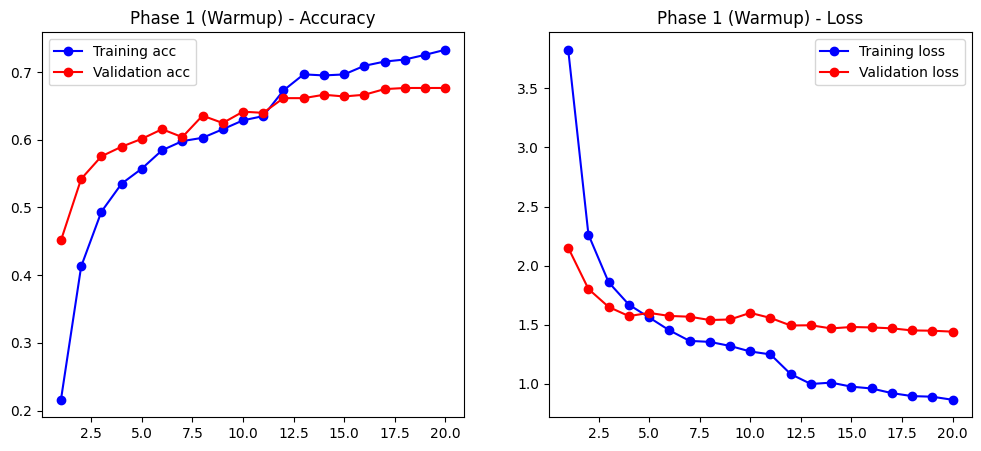

In [9]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_1, "Phase 1 (Warmup)")

In [ ]:
model.load_weights("best_phase1_new.h5")
base_model.trainable = True

for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint2 = ModelCheckpoint("best_final_model_new.h5", save_best_only=True)
early_stop = EarlyStopping(patience=9, restore_best_weights=True)
reduce_lr2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint2, reduce_lr2]
)

Epoch 1/30


2025-12-09 00:50:20.606089: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1005] Compiling 10 configs for gemm_fusion_dot.14053 on a single thread.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.5559 - loss: 1.7673

600/600 ━━━━━━━━━━━━━━━━━━━━ 514s 747ms/step - accuracy: 0.5672 - loss: 1.7071 - val_accuracy: 0.6480 - val_loss: 1.5790 - learning_rate: 1.0000e-05
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.5944 - loss: 1.4960

600/600 ━━━━━━━━━━━━━━━━━━━━ 360s 599ms/step - accuracy: 0.5959 - loss: 1.4847 - val_accuracy: 0.6530 - val_loss: 1.5448 - learning_rate: 1.0000e-05
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6134 - loss: 1.3849

600/600 ━━━━━━━━━━━━━━━━━━━━ 361s 601ms/step - accuracy: 0.6237 - loss: 1.3695 - val_accuracy: 0.6530 - val_loss: 1.5258 - learning_rate: 1.0000e-05
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6306 - loss: 1.3030

600/600 ━━━━━━━━━━━━━━━━━━━━ 340s 565ms/step - accuracy: 0.6305 - loss: 1.2993 - val_accuracy: 0.6522 - val_loss: 1.5142 - learning_rate: 1.0000e-05
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6307 - loss: 1.2742

600/600 ━━━━━━━━━━━━━━━━━━━━ 334s 557ms/step - accuracy: 0.6341 - loss: 1.2605 - val_accuracy: 0.6572 - val_loss: 1.5084 - learning_rate: 1.0000e-05
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6426 - loss: 1.1868

600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 554ms/step - accuracy: 0.6379 - loss: 1.2057 - val_accuracy: 0.6622 - val_loss: 1.5022 - learning_rate: 1.0000e-05
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.6479 - loss: 1.2155

600/600 ━━━━━━━━━━━━━━━━━━━━ 328s 546ms/step - accuracy: 0.6480 - loss: 1.2033 - val_accuracy: 0.6622 - val_loss: 1.4985 - learning_rate: 1.0000e-05
Epoch 8/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6547 - loss: 1.1560

600/600 ━━━━━━━━━━━━━━━━━━━━ 332s 552ms/step - accuracy: 0.6575 - loss: 1.1612 - val_accuracy: 0.6622 - val_loss: 1.4982 - learning_rate: 1.0000e-05
Epoch 9/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6615 - loss: 1.1468

600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 556ms/step - accuracy: 0.6540 - loss: 1.1583 - val_accuracy: 0.6622 - val_loss: 1.4926 - learning_rate: 1.0000e-05
Epoch 10/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.6586 - loss: 1.0887

600/600 ━━━━━━━━━━━━━━━━━━━━ 338s 562ms/step - accuracy: 0.6581 - loss: 1.1144 - val_accuracy: 0.6639 - val_loss: 1.4877 - learning_rate: 1.0000e-05
Epoch 11/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6587 - loss: 1.1092

600/600 ━━━━━━━━━━━━━━━━━━━━ 330s 550ms/step - accuracy: 0.6594 - loss: 1.1251 - val_accuracy: 0.6622 - val_loss: 1.4870 - learning_rate: 1.0000e-05
Epoch 12/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6720 - loss: 1.0705

600/600 ━━━━━━━━━━━━━━━━━━━━ 331s 551ms/step - accuracy: 0.6700 - loss: 1.0859 - val_accuracy: 0.6647 - val_loss: 1.4819 - learning_rate: 1.0000e-05
Epoch 13/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6706 - loss: 1.1002

600/600 ━━━━━━━━━━━━━━━━━━━━ 334s 556ms/step - accuracy: 0.6701 - loss: 1.0876 - val_accuracy: 0.6681 - val_loss: 1.4783 - learning_rate: 1.0000e-05
Epoch 14/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 554ms/step - accuracy: 0.6806 - loss: 1.0565 - val_accuracy: 0.6689 - val_loss: 1.4810 - learning_rate: 1.0000e-05
Epoch 15/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.6748 - loss: 1.0342

600/600 ━━━━━━━━━━━━━━━━━━━━ 338s 563ms/step - accuracy: 0.6789 - loss: 1.0271 - val_accuracy: 0.6714 - val_loss: 1.4754 - learning_rate: 1.0000e-05
Epoch 16/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6752 - loss: 1.0376

600/600 ━━━━━━━━━━━━━━━━━━━━ 335s 558ms/step - accuracy: 0.6796 - loss: 1.0370 - val_accuracy: 0.6722 - val_loss: 1.4719 - learning_rate: 1.0000e-05
Epoch 17/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.6871 - loss: 1.0126

600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 554ms/step - accuracy: 0.6888 - loss: 1.0023 - val_accuracy: 0.6772 - val_loss: 1.4668 - learning_rate: 1.0000e-05
Epoch 18/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 554ms/step - accuracy: 0.6910 - loss: 1.0176 - val_accuracy: 0.6747 - val_loss: 1.4673 - learning_rate: 1.0000e-05
Epoch 19/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6874 - loss: 1.0100

600/600 ━━━━━━━━━━━━━━━━━━━━ 334s 555ms/step - accuracy: 0.6906 - loss: 1.0129 - val_accuracy: 0.6722 - val_loss: 1.4593 - learning_rate: 1.0000e-05
Epoch 20/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6885 - loss: 0.9936

600/600 ━━━━━━━━━━━━━━━━━━━━ 343s 571ms/step - accuracy: 0.6930 - loss: 0.9917 - val_accuracy: 0.6772 - val_loss: 1.4576 - learning_rate: 1.0000e-05
Epoch 21/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6939 - loss: 1.0015

600/600 ━━━━━━━━━━━━━━━━━━━━ 342s 570ms/step - accuracy: 0.6953 - loss: 0.9887 - val_accuracy: 0.6781 - val_loss: 1.4554 - learning_rate: 1.0000e-05
Epoch 22/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6987 - loss: 0.9801

600/600 ━━━━━━━━━━━━━━━━━━━━ 332s 553ms/step - accuracy: 0.6889 - loss: 0.9861 - val_accuracy: 0.6756 - val_loss: 1.4531 - learning_rate: 1.0000e-05
Epoch 23/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7075 - loss: 0.9660

600/600 ━━━━━━━━━━━━━━━━━━━━ 337s 561ms/step - accuracy: 0.7004 - loss: 0.9656 - val_accuracy: 0.6831 - val_loss: 1.4490 - learning_rate: 1.0000e-05
Epoch 24/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.7109 - loss: 0.9565

600/600 ━━━━━━━━━━━━━━━━━━━━ 337s 561ms/step - accuracy: 0.7026 - loss: 0.9622 - val_accuracy: 0.6847 - val_loss: 1.4395 - learning_rate: 1.0000e-05
Epoch 25/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6992 - loss: 0.9759

600/600 ━━━━━━━━━━━━━━━━━━━━ 339s 564ms/step - accuracy: 0.7015 - loss: 0.9667 - val_accuracy: 0.6822 - val_loss: 1.4354 - learning_rate: 1.0000e-05
Epoch 26/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 336s 560ms/step - accuracy: 0.7077 - loss: 0.9311 - val_accuracy: 0.6839 - val_loss: 1.4387 - learning_rate: 1.0000e-05
Epoch 27/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7087 - loss: 0.9548

600/600 ━━━━━━━━━━━━━━━━━━━━ 330s 549ms/step - accuracy: 0.7055 - loss: 0.9613 - val_accuracy: 0.6839 - val_loss: 1.4338 - learning_rate: 1.0000e-05
Epoch 28/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 331s 551ms/step - accuracy: 0.7189 - loss: 0.9102 - val_accuracy: 0.6822 - val_loss: 1.4347 - learning_rate: 1.0000e-05
Epoch 29/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 555ms/step - accuracy: 0.7191 - loss: 0.9037 - val_accuracy: 0.6889 - val_loss: 1.4364 - learning_rate: 1.0000e-05
Epoch 30/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7180 - loss: 0.8998

600/600 ━━━━━━━━━━━━━━━━━━━━ 333s 555ms/step - accuracy: 0.7141 - loss: 0.9101 - val_accuracy: 0.6839 - val_loss: 1.4309 - learning_rate: 1.0000e-05


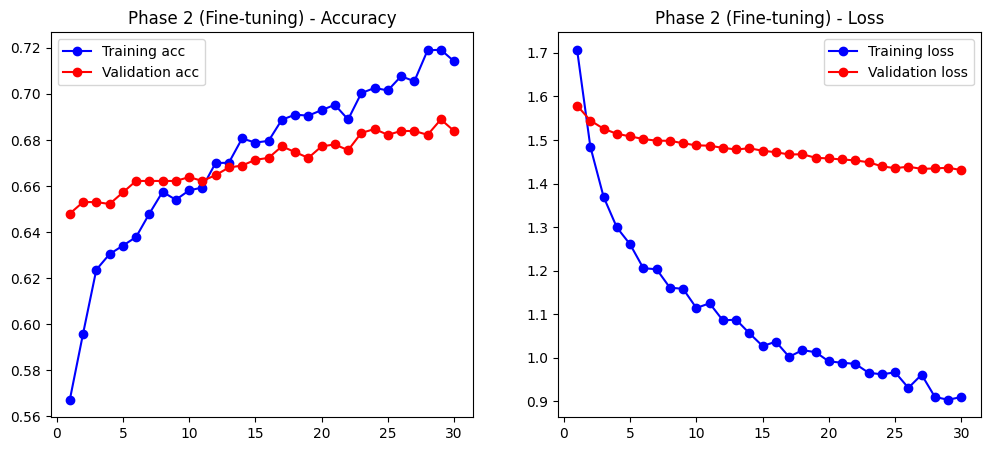

In [11]:
def plot_history(hist, phase_name):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{phase_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{phase_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_2, "Phase 2 (Fine-tuning)")

In [12]:
model.load_weights("best_final_model_new.h5")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 355ms/step - accuracy: 0.7198 - loss: 1.3424
Final Test Accuracy: 71.98%
